# Linear shell arch model

## Gmsh model

You can find the Gmsh modeling instructions for this model here:
[Generating a shell model with the Gmsh Python API](https://bleyerj.github.io/comet-fenicsx/tours/shells/I_beam_gmsh/I_beam_gmsh.html#)

<a href="https://sm.ms/image/wDnrAuzj4SR7H6O" target="_blank"><img src="https://s2.loli.net/2025/02/27/wDnrAuzj4SR7H6O.png" ></a>

In [1]:
import gmsh
import numpy as np

filename = "I_beam"
# I-beam profile
wb = 0.2  # bottom flange width
wt = 0.3  # top flange width
h = 0.5  # web height
# Arch geometry
theta = np.pi / 6  # arch opening half-angle
L = 10.0  # chord length
R = L / 2 / np.sin(theta)  # arch radius
f = R - L / 2 / np.tan(theta)  # arch rise

In [2]:
gmsh.initialize()
gmsh.model.add(filename)
geom = gmsh.model.geo

In [3]:
lcar = 0.1  # characteristic mesh size density (will not be used)
bottom_points = [
    geom.addPoint(0, -wb / 2, -h / 2, lcar),
    geom.addPoint(0, 0, -h / 2, lcar),
    geom.addPoint(0, wb / 2, -h / 2, lcar),
]
top_points = [
    geom.addPoint(0, -wt / 2, h / 2, lcar),
    geom.addPoint(0, 0, h / 2, lcar),
    geom.addPoint(0, wt / 2, h / 2, lcar),
]
bottom_flange = [
    geom.addLine(bottom_points[0], bottom_points[1]),
    geom.addLine(bottom_points[1], bottom_points[2]),
]
web = [geom.addLine(bottom_points[1], top_points[1])]
top_flange = [
    geom.addLine(top_points[0], top_points[1]),
    geom.addLine(top_points[1], top_points[2]),
]
start_section = bottom_flange + web + top_flange

In [4]:
end_bottom_flange = []
end_top_flange = []
end_web = []
surfaces = []
for ini, end in zip([bottom_flange, web, top_flange], [end_bottom_flange, end_web, end_top_flange]):
    for l in ini:
        outDimTags = geom.revolve(
            [(1, l)],
            L / 2,
            0,
            -(R - f),
            0,
            1,
            0,
            2 * theta,
            numElements=[50],
            heights=[1.0],
        )
        end.append(outDimTags[0][1])
        surfaces.append(outDimTags[1][1])
        geom.synchronize()
end_section = end_bottom_flange + end_web + end_top_flange

Add a physical group. The name of the physical group is important for the subsequent conversion.

In [5]:
gmsh.model.add_physical_group(dim=1, tags=start_section, tag=1, name="start_section")
gmsh.model.add_physical_group(dim=1, tags=end_section, tag=2, name="end_section")

plane_tags = gmsh.model.get_entities(dim=2)
plane_tags = [tag[1] for tag in plane_tags]
gmsh.model.add_physical_group(dim=2, tags=plane_tags, tag=3, name="surfaces")

3

In [6]:
# for quad mesh
# if does not work, try to use Recombine 2D in gmsh GUI
# you can find options in https://gmsh.info/doc/texinfo/gmsh.html#Mesh-options
gmsh.option.setNumber("Mesh.RecombineAll", 1)
gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
gmsh.option.setNumber("Mesh.Algorithm", 8)
gmsh.option.setNumber("Mesh.ElementOrder", 1)
gmsh.model.mesh.generate(dim=2)

gmsh.option.setNumber("Mesh.SaveAll", 1)
# gmsh.write(filename + ".msh")
# gmsh.fltk.run()  # uncomment to visualize the geometry
gmsh.finalize()

## Gmsh model to openseespy

In [7]:
import openseespy.opensees as ops
import opstool as opst

ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)

### Read mesh data

In [8]:
GmshModel = opst.pre.Gmsh2OPS(ndm=3, ndf=6)
GmshModel.read_gmsh_file("I_beam.msh")

Info:: 3 Physical Names.
Info:: 1076 Nodes; MaxNodeTag 1076; MinNodeTag 1.
Info:: 1357 Elements; MaxEleTag 1357; MinEleTag 1.
Info:: Geometry Information >>>
38 Entities: 17 Point; 16 Curves; 5 Surfaces; 0 Volumes.

Info:: Physical Groups Information >>>
3 Physical Groups.
Physical Group names: ['start_section', 'end_section', 'surfaces']

Info:: Mesh Information >>>
1076 Nodes; MaxNodeTag 1076; MinNodeTag 1.
1340 Elements; MaxEleTag 1357; MinEleTag 18.



In [9]:
GmshModel.get_physical_groups()

{'start_section': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
 'end_section': [(1, 6), (1, 10), (1, 14), (1, 18), (1, 22)],
 'surfaces': [(2, 9), (2, 13), (2, 17), (2, 21), (2, 25)]}

### Create nodes

In [10]:
node_tags = GmshModel.create_node_cmds()

Get boundary points by physics group:

In [11]:
fixed_tags = GmshModel.get_boundary_dim_tags(physical_group_names=["start_section", "end_section"], include_self=True)
fixed_node_tags = GmshModel.get_node_tags(dim_entity_tags=fixed_tags)

for node_tag in fixed_node_tags:
    ops.fix(node_tag, *[1, 1, 1, 1, 1, 1])

### Create shell elements

We use [ASDShellQ4](https://opensees.github.io/OpenSeesDocumentation/user/manual/model/elements/ASDShellQ4.html) to create the shell elements:


In [12]:
# material parameters
thick = 1e-2  # 1 cm
E = 210e6  # 210 GPa
nu = 0.3

# create a fiber shell section with 5 layers of material 1
# each layer has a thickness = thick / 5
matTag, secTag = 1, 11
ops.nDMaterial("ElasticIsotropic", matTag, E, nu)
n_layers = 5
args = [matTag, thick / n_layers] * n_layers
ops.section("LayeredShell", secTag, n_layers, *args)

In [13]:
# element ASDShellT3 $eleTag $n1 $n2 $n3 $secTag

shell_ele_tags = GmshModel.create_element_cmds(
    ops_ele_type="ASDShellQ4",
    ops_ele_args=[secTag],
    physical_group_names=["surfaces"],
)

# remove void nodes maybe generated by gmsh
opst.pre.remove_void_nodes()

Using ASDShellQ4 - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


Info:: Free nodes with tags [9, 10, 12, 15, 17] have been removed!

[9, 10, 12, 15, 17]

### Visualization model geometry

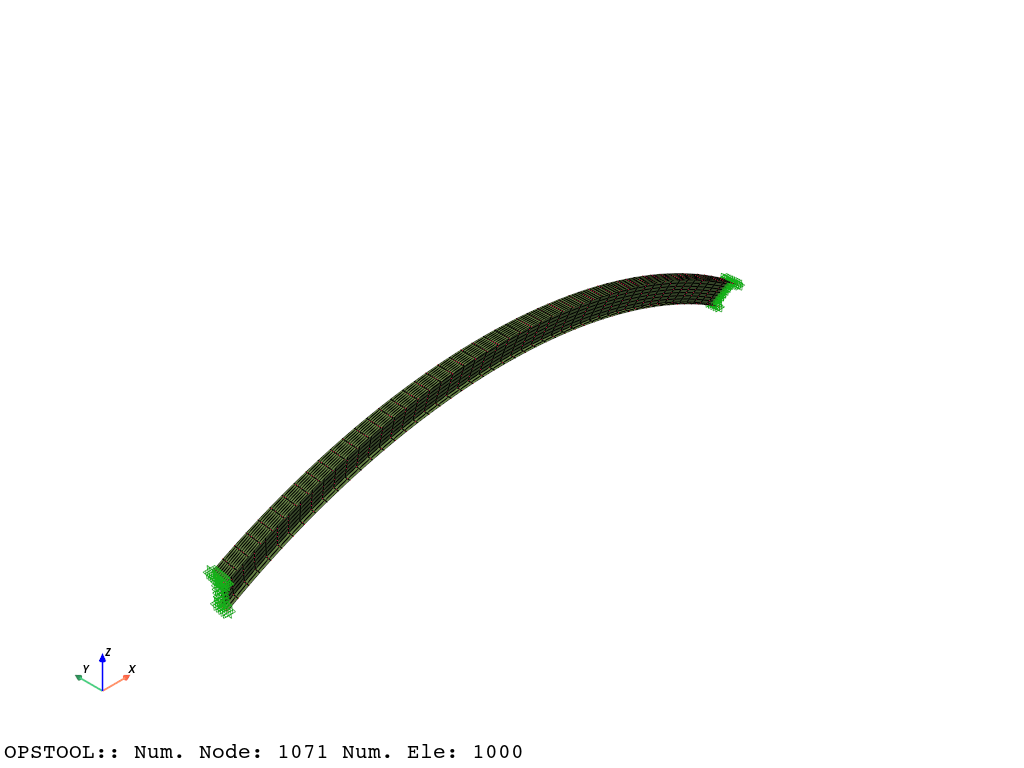

In [14]:
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model()
fig.show(jupyter_backend="jupyterlab")

### Model Mass and Gravity Load

In [15]:
g = 9.81
rho = 7.85  #  ton/m3
MODEL_MASS = opst.pre.ModelMass()
MODEL_MASS.add_mass_from_surf(ele_tags=shell_ele_tags, rho=rho, d=thick)
MODEL_MASS.generate_ops_node_mass()

In [16]:
print(MODEL_MASS.get_total_mass())

0.768761372463413


In [17]:
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
MODEL_MASS.generate_ops_gravity_load(direction="z", factor=-g)

### Eigen Visulaization

Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Eigen data has been saved to .opstool.output/EigenData-Auto.nc!

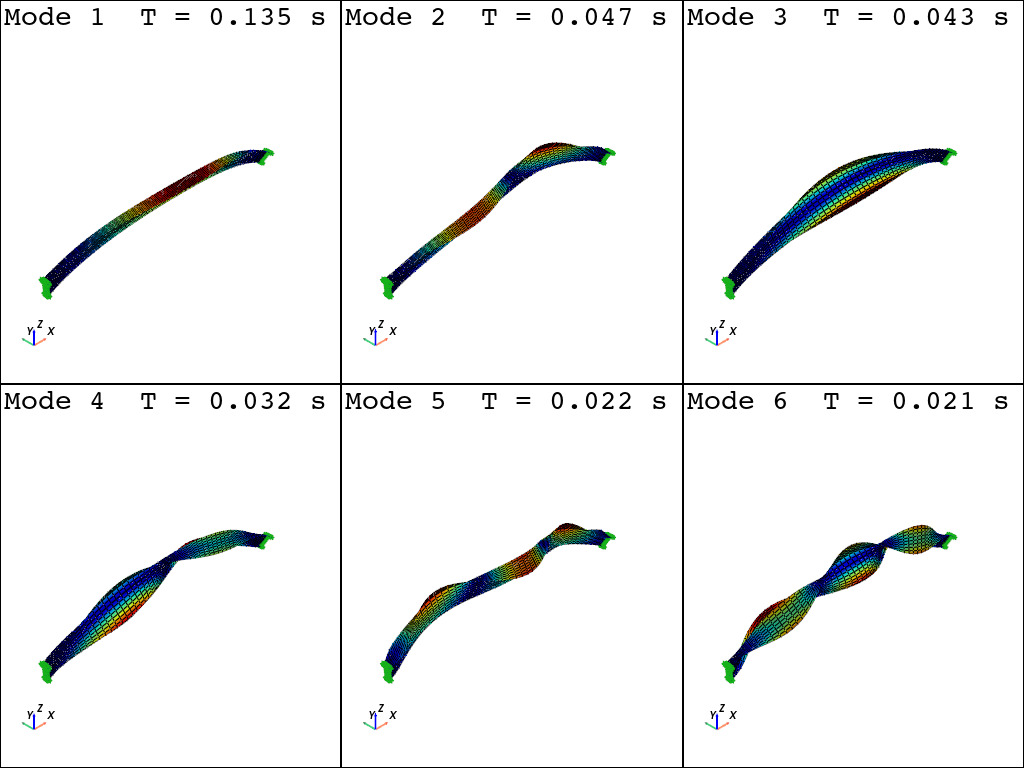

In [18]:
fig = opst.vis.pyvista.plot_eigen(mode_tags=[1, 6], subplots=True)
fig.show(jupyter_backend="jupyterlab")